<a href="https://colab.research.google.com/github/O-Kpy/Kaggle/blob/main/Dacon_%EC%8B%A0%EC%9A%A9_%EC%98%88%EC%B8%A1_%EB%B3%B5%EC%8A%B5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

In [40]:
train = pd.read_csv('/content/drive/MyDrive/dataset/Dacon/대회/신용카드 사용자 연체 예측 AI 경진대회/train.csv')
test = pd.read_csv('/content/drive/MyDrive/dataset/Dacon/대회/신용카드 사용자 연체 예측 AI 경진대회/test.csv')
print(f'train shape:{train.shape}')
print(f'test shape:{test.shape}')
test_index = test['index']

train shape:(26457, 20)
test shape:(10000, 19)


In [41]:
data = pd.concat([train, test], axis=0)

In [80]:
data

,index,gender,car,reality,child_num,income_total,income_type,edu_type,family_type,house_type,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,work_phone,phone,email,occyp_type,family_size,begin_month,credit,begin_years,DAYS_EMPLOYED_ANOM,age,employed,working_ratio,daily_wage,property,age_cut,employed_cut,daily_wage_cut
0,0,0,0,0,0,202500.0,0,1,1,2,-13899,-4709.0,1,0,0,0,etc,2.0,-6.0,1.0,0.500000,False,38.079452,12.901370,33.880135,43.002761,1,35-40,10-20,0-1600
1,1,0,0,1,1,247500.0,0,4,0,1,-11380,-1540.0,1,0,0,1,Laborers,3.0,-5.0,1.0,0.416667,False,31.178082,4.219178,13.532513,160.714286,2,30-35,0-10,0-1600
2,2,1,1,1,0,450000.0,4,1,1,1,-19087,-4434.0,1,0,1,0,Managers,2.0,-22.0,2.0,1.833333,False,52.293151,12.147945,23.230471,101.488498,4,51-58,10-20,0-1600
3,3,0,0,1,0,202500.0,0,4,1,1,-15088,-2092.0,1,0,1,0,Sales staff,2.0,-37.0,0.0,3.083333,False,41.336986,5.731507,13.865323,96.797323,3,40-45,0-10,0-1600
4,4,0,1,1,0,157500.0,2,1,1,1,-15037,-2105.0,1,0,0,0,Managers,2.0,-26.0,2.0,2.166667,False,41.197260,5.767123,13.998803,74.821853,3,40-45,0-10,0-1600
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,36452,0,1,1,0,202500.0,4,2,1,1,-18593,-5434.0,1,1,1,0,Accountants,2.0,-19.0,NaN,1.583333,False,50.939726,14.887671,29.226053,37.265366,5,45-51,10-20,0-1600
9996,36453,1,1,1,0,202500.0,4,4,0,1,-10886,-1315.0,1,1,0,0,Laborers,2.0,-34.0,NaN,2.833333,False,29.824658,3.602740,12.079735,153.992395,4,20-30,0-10,0-1600
9997,36454,0,0,1,0,292500.0,4,4,1,1,-21016,-14018.0,1,0,0,0,Medicine staff,2.0,-55.0,NaN,4.583333,False,57.578082,38.405479,66.701561,20.866029,2,51-58,30-40,0-1600
9998,36455,0,1,0,0,180000.0,0,4,1,1,-16541,-1085.0,1,0,1,0,etc,2.0,-33.0,NaN,2.750000,False,45.317808,2.972603,6.559458,165.898618,3,40-45,0-10,0-1600


In [5]:
from sklearn.preprocessing import LabelEncoder

In [42]:
encoders = LabelEncoder()

for i in data.select_dtypes('object'):
  if i == 'occyp_type':
    continue
  else:
    data[i] = encoders.fit_transform(data[i])

In [ ]:
encoders = LabelEncoder()

for i in data.select_dtypes('object'):
  if data[i].nunique() <= 2:
    data[i] = encoders.fit_transform(data[i])
  elif i == 'occyp_type':
    continue
  else:
    data = pd.get_dummies(data=data, columns=[i])

# occyp_type만 남기고 다 인코딩

In [43]:
corr_matrix = data.corr()
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
to_drop = [c for c in upper.columns if any(abs(upper[c])>0.9)]
to_drop
# 제거할 Feature는 안보인다.

[]

In [44]:
def plot_categoricals(x, y, data, annotate = True):
    """Plot counts of two categoricals.
    Size is raw count for each grouping.
    Percentages are for a given value of y."""
    
    # Raw counts 
    raw_counts = pd.DataFrame(data.groupby(y)[x].value_counts(normalize = False))
    raw_counts = raw_counts.rename(columns = {x: 'raw_count'})
    
    # Calculate counts for each group of x and y
    counts = pd.DataFrame(data.groupby(y)[x].value_counts(normalize = True))
    
    # Rename the column and reset the index
    counts = counts.rename(columns = {x: 'normalized_count'}).reset_index()
    counts['percent'] = 100 * counts['normalized_count']
    
    # Add the raw count
    counts['raw_count'] = list(raw_counts['raw_count'])
    
    plt.figure(figsize = (14, 10))
    # Scatter plot sized by percent
    plt.scatter(counts[x], counts[y], edgecolor = 'k', color = 'lightgreen',
                s = 100 * np.sqrt(counts['raw_count']), marker = 'o',
                alpha = 0.6, linewidth = 1.5)
    
    if annotate:
        # Annotate the plot with text
        for i, row in counts.iterrows():
            # Put text with appropriate offsets
            plt.annotate(xy = (row[x] - (1 / counts[x].nunique()), 
                               row[y] - (0.15 / counts[y].nunique())),
                         color = 'navy',
                         s = f"{round(row['percent'], 1)}%")
        
    # Set tick marks
    plt.yticks(counts[y].unique())
    plt.xticks(counts[x].unique())
    
    # Transform min and max to evenly space in square root domain
    sqr_min = int(np.sqrt(raw_counts['raw_count'].min()))
    sqr_max = int(np.sqrt(raw_counts['raw_count'].max()))
    
    # 5 sizes for legend
    msizes = list(range(sqr_min, sqr_max,
                        int(( sqr_max - sqr_min) / 5)))
    markers = []
    
    # Markers for legend
    for size in msizes:
        markers.append(plt.scatter([], [], s = 100 * size, 
                                   label = f'{int(round(np.square(size) / 100) * 100)}', 
                                   color = 'lightgreen',
                                   alpha = 0.6, edgecolor = 'k', linewidth = 1.5))
        
    # Legend and formatting
    plt.legend(handles = markers, title = 'Counts',
               labelspacing = 3, handletextpad = 2,
               fontsize = 16,
               loc = (1.10, 0.19))
    
    plt.annotate(f'* Size represents raw count while % is for a given y value.',
                 xy = (0, 1), xycoords = 'figure points', size = 10)
    
    # Adjust axes limits
    plt.xlim((counts[x].min() - (6 / counts[x].nunique()), 
              counts[x].max() + (6 / counts[x].nunique())))
    plt.ylim((counts[y].min() - (4 / counts[y].nunique()), 
              counts[y].max() + (4 / counts[y].nunique())))
    plt.grid(None)
    plt.xlabel(f"{x}"); plt.ylabel(f"{y}"); plt.title(f"{y} vs {x}");

# Feature Engineering

In [ ]:
data['begin_month'] = abs(data['begin_month'])
data['DAYS_EMPLOYED'] = abs(data['DAYS_EMPLOYED'])
data['DAYS_BIRTH'] = abs(data['DAYS_BIRTH'])

In [45]:
data['begin_years'] = data['begin_month'] / -12

In [46]:
data['DAYS_EMPLOYED_ANOM'] = data['DAYS_EMPLOYED'] == 365243
data.loc[data['DAYS_EMPLOYED'] == 365243, 'DAYS_EMPLOYED'] = np.NaN

In [48]:
data['age'] = data['DAYS_BIRTH'] / -365
data['employed'] = data['DAYS_EMPLOYED'] / -365

In [49]:
data['working_ratio'] = data['DAYS_EMPLOYED'] / data['DAYS_BIRTH'] * 100
data['daily_wage'] = data['income_total'] / -data['DAYS_EMPLOYED']

In [52]:
data['property'] = data['car'] + data['reality'] + data['phone'] + data['FLAG_MOBIL'] + data['work_phone']

In [53]:
labels = ['20-30', '30-35', '35-40', '40-45', '45-51', '51-58', '58-']
data['age_cut'] = pd.qcut(data['age'], 7, labels=labels)

In [60]:
labels = ['0-10', '10-20', '20-30', '30-40', '40-50']
data['employed_cut'] = pd.cut(data['employed'], bins=np.linspace(0,50, num=6), labels=labels)

In [71]:
labels = ['0-1600', '1600-3200', '3200-4800', '4800-6400', '6400-8000']
data['daily_wage_cut'] = pd.cut(data['daily_wage'], bins=np.linspace(0,8000, num=6), labels=labels)

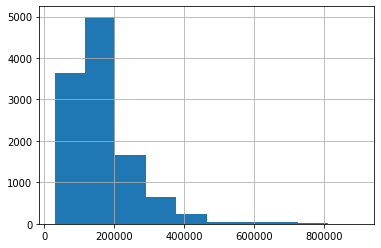

In [76]:
data[data['occyp_type'].isnull()]['income_total'].hist()
# 어느 특정 직업의 정상적인 분포같음

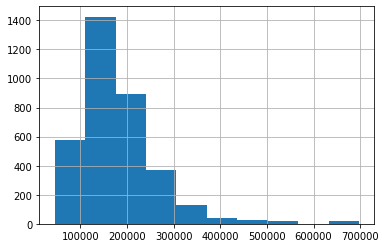

In [77]:
data[data['occyp_type'] == 'Sales staff']['income_total'].hist()
# Nan값의 연봉에 비하여 분포 차이가 그렇게 많이 나지도 않는다.

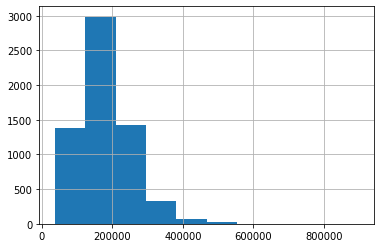

In [78]:
data[data['occyp_type'] == 'Laborers']['income_total'].hist()

In [ ]:
# income_total, age, employed를 카테고리 화 Feature Engineering

In [79]:
data['occyp_type'] = data['occyp_type'].fillna('etc')

In [81]:
data = pd.get_dummies(data=data, columns=['occyp_type', 'age_cut', 'employed_cut',	'daily_wage_cut'])

In [ ]:
# aggregation은 다음에 시도해보자...

In [95]:
def missing_data(data):
  total = data.isnull().sum()
  percent = round(data.isnull().sum()/len(data)*100, 2)

  table = pd.concat([total, percent], axis=1, keys=['Total', 'Percent']).sort_values('Percent', ascending=False)
  table = table[table['Total'] != 0]
  return table

In [100]:
missing_data(data)

,Total,Percent
credit,10000,27.43


In [97]:
from sklearn.impute import SimpleImputer

In [99]:
imputer = SimpleImputer(strategy='median')
for i in data.drop(columns='credit').columns:
  data[i] = imputer.fit_transform(data[[i]])

In [101]:
x_train = data[data['credit'].notnull()]
x_test = data[data['credit'].isnull()]
x_test = x_test.drop(['credit'], axis=1)

print(f'Whole data set shape:{data.shape}')
print(f'train set shape:{x_train.shape}, test set shape:{x_test.shape}')

Whole data set shape:(36457, 62)
train set shape:(26457, 62), test set shape:(10000, 61)
